In [1]:
import pickle
import numpy as np
from itertools import permutations, combinations
import statistics
import math
import random
import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from graphutils import utils
from lib.utilities import Repository

data_path = '/data/gpfs/projects/punim2258'

In [2]:
seeds = [20250212, 20250214, 20250314]

In [ ]:
plt.close("all")
fontsize = 14
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 
task = 'col'
final_stats = []
for seed in seeds:
    all_acc_vals = []
    all_mrr_vals = []
    figure, axis = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(12, 10))
    plot_y = [[[], []], [[], []]]
    sizes = list(range(3, 9))
    for test_id in range(5):
        ted = {'ra3':[], 'mrr':[]}
        ginepl = {'ra3':[], 'mrr':[]}
        ginep = {'ra3':[], 'mrr':[]}
        ginem = {'ra3':[], 'mrr':[]}
        for main_size in sizes:
            ted_result = pickle.load(open(f'{data_path}/network_data/chunk_ted_results/{seed}_{main_size}_{test_id}_unbiased.pickle', 'rb'))
            ted['ra3'].append(res['ra3'][0])
            ted['mrr'].append(res['mrr'][0])

            res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{main_size}_{test_id}_unbiased_gine.pickle', 'rb'))
            ginepl['ra3'].append([statistics.mean(res['ra3']), statistics.stdev(res['ra3'])])
            ginepl['mrr'].append([statistics.mean(res['mrr']), statistics.stdev(res['mrr'])])

            res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{main_size}_{test_id}_unbiased_gine_alone.pickle', 'rb'))
            ginep['ra3'].append([statistics.mean(res['ra3']), statistics.stdev(res['ra3'])])
            ginep['mrr'].append([statistics.mean(res['mrr']), statistics.stdev(res['mrr'])])

            res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{main_size}_{test_id}_unbiased_gine_alone_single_context.pickle', 'rb'))
            ginem['ra3'].append([statistics.mean(res['ra3']), statistics.stdev(res['ra3'])])
            ginem['mrr'].append([statistics.mean(res['mrr']), statistics.stdev(res['mrr'])])

            plot_y[test_id][0].append([minimum[0], means[0], maximum[0], ted_result[test_id]['acc']])
            plot_y[test_id][1].append([minimum[1], means[1], maximum[1], ted_result[test_id]['mrr']])


    overall = overall_stat(seed, sizes, plot_y, chunk_sizes)
    plot_y = np.array(plot_y)

    halves = ['First-half', 'Second-half']
    titles = ['R@3', 'MRR']
    for i in [0,1]:
        for j in [0, 1]:
            axis[i, j].plot(sizes, plot_y[i][j][:,0], marker='o', markersize=8, linestyle=':', linewidth=2, color='purple', label='Min TRIAD')
            axis[i, j].plot(sizes, plot_y[i][j][:,1], marker='o', markersize=8, linestyle='-', linewidth=2, color='green', label='Avg TRIAD')
            axis[i, j].plot(sizes, plot_y[i][j][:,2], marker='o', markersize=8, linestyle='--', linewidth=2, color='red', label='Max TRIAD')
            axis[i, j].plot(sizes, plot_y[i][j][:,3], marker='v', markersize=8, linestyle='-.', linewidth=2, color='blue', label='Max REACT')
            # axis[i, j].plot(sizes, plot_y[i][j][:,4], marker='v', color='cyan', label='avg our generic')
            axis[i, j].grid()
            axis[i, j].set_title(f'{titles[j]} ({halves[i]})', fontsize=fontsize, fontweight='bold')
            axis[i, j].tick_params(labelsize=fontsize)
    
    axis[2, 0].plot(sizes, overall["acc"][:,0], marker='o', markersize=8, linestyle=':', linewidth=2, color='purple', label='Min TRIAD')
    axis[2, 0].plot(sizes, overall["acc"][:,1], marker='o', markersize=8, linestyle='-', linewidth=2, color='green', label='Avg TRIAD')
    axis[2, 0].plot(sizes, overall["acc"][:,2], marker='o', markersize=8, linestyle='--', linewidth=2, color='red', label='Max TRIAD')
    axis[2, 0].plot(sizes, overall["acc"][:,3], marker='v', markersize=8, linestyle='-.', linewidth=2, color='blue', label='Max REACT')
    axis[2, 0].grid()
    axis[2, 0].set_title('R@3 (Overall)', fontsize=fontsize, fontweight='bold')
    axis[2, 0].tick_params(labelsize=fontsize)

    axis[2, 1].plot(sizes, overall["mrr"][:,0], marker='o', markersize=8, linestyle=':', linewidth=2, color='purple', label='Min TRIAD')
    axis[2, 1].plot(sizes, overall["mrr"][:,1], marker='o', markersize=8, linestyle='-', linewidth=2, color='green', label='Avg TRIAD')
    axis[2, 1].plot(sizes, overall["mrr"][:,2], marker='o', markersize=8, linestyle='--', linewidth=2, color='red', label='Max TRIAD')
    axis[2, 1].plot(sizes, overall["mrr"][:,3], marker='v', markersize=8, linestyle='-.', linewidth=2, color='blue', label='Max REACT')
    axis[2, 1].grid()
    axis[2, 1].set_title('MRR (Overall)', fontsize=fontsize, fontweight='bold')
    axis[2, 1].tick_params(labelsize=fontsize)
    
    # figure.suptitle(f'seed={seed}')
    handles, labels = axis[0,0].get_legend_handles_labels()
    lgd = figure.legend(handles, labels, loc='upper center', ncols=4, fontsize=fontsize, bbox_to_anchor=(0.5, 1.045))
    lblx = figure.supxlabel('Context Size', fontsize=fontsize+1, fontweight='bold')
    lbly = figure.supylabel('Accuracy', fontsize=fontsize+1, fontweight='bold', x=0.01)
    plt.tight_layout()
    plt.savefig(f'{data_path}/network_data/result_plots/{task}_{seed}.eps', format='eps', bbox_extra_artists=(lgd, lblx, lbly), bbox_inches='tight')
    plt.show()

    final_stats.append(overall['acc'][:, 1] - overall['acc'][:, 3])

final_stats = np.array(final_stats)
print(final_stats.min(), final_stats.max(), final_stats.mean(), final_stats.std())
    

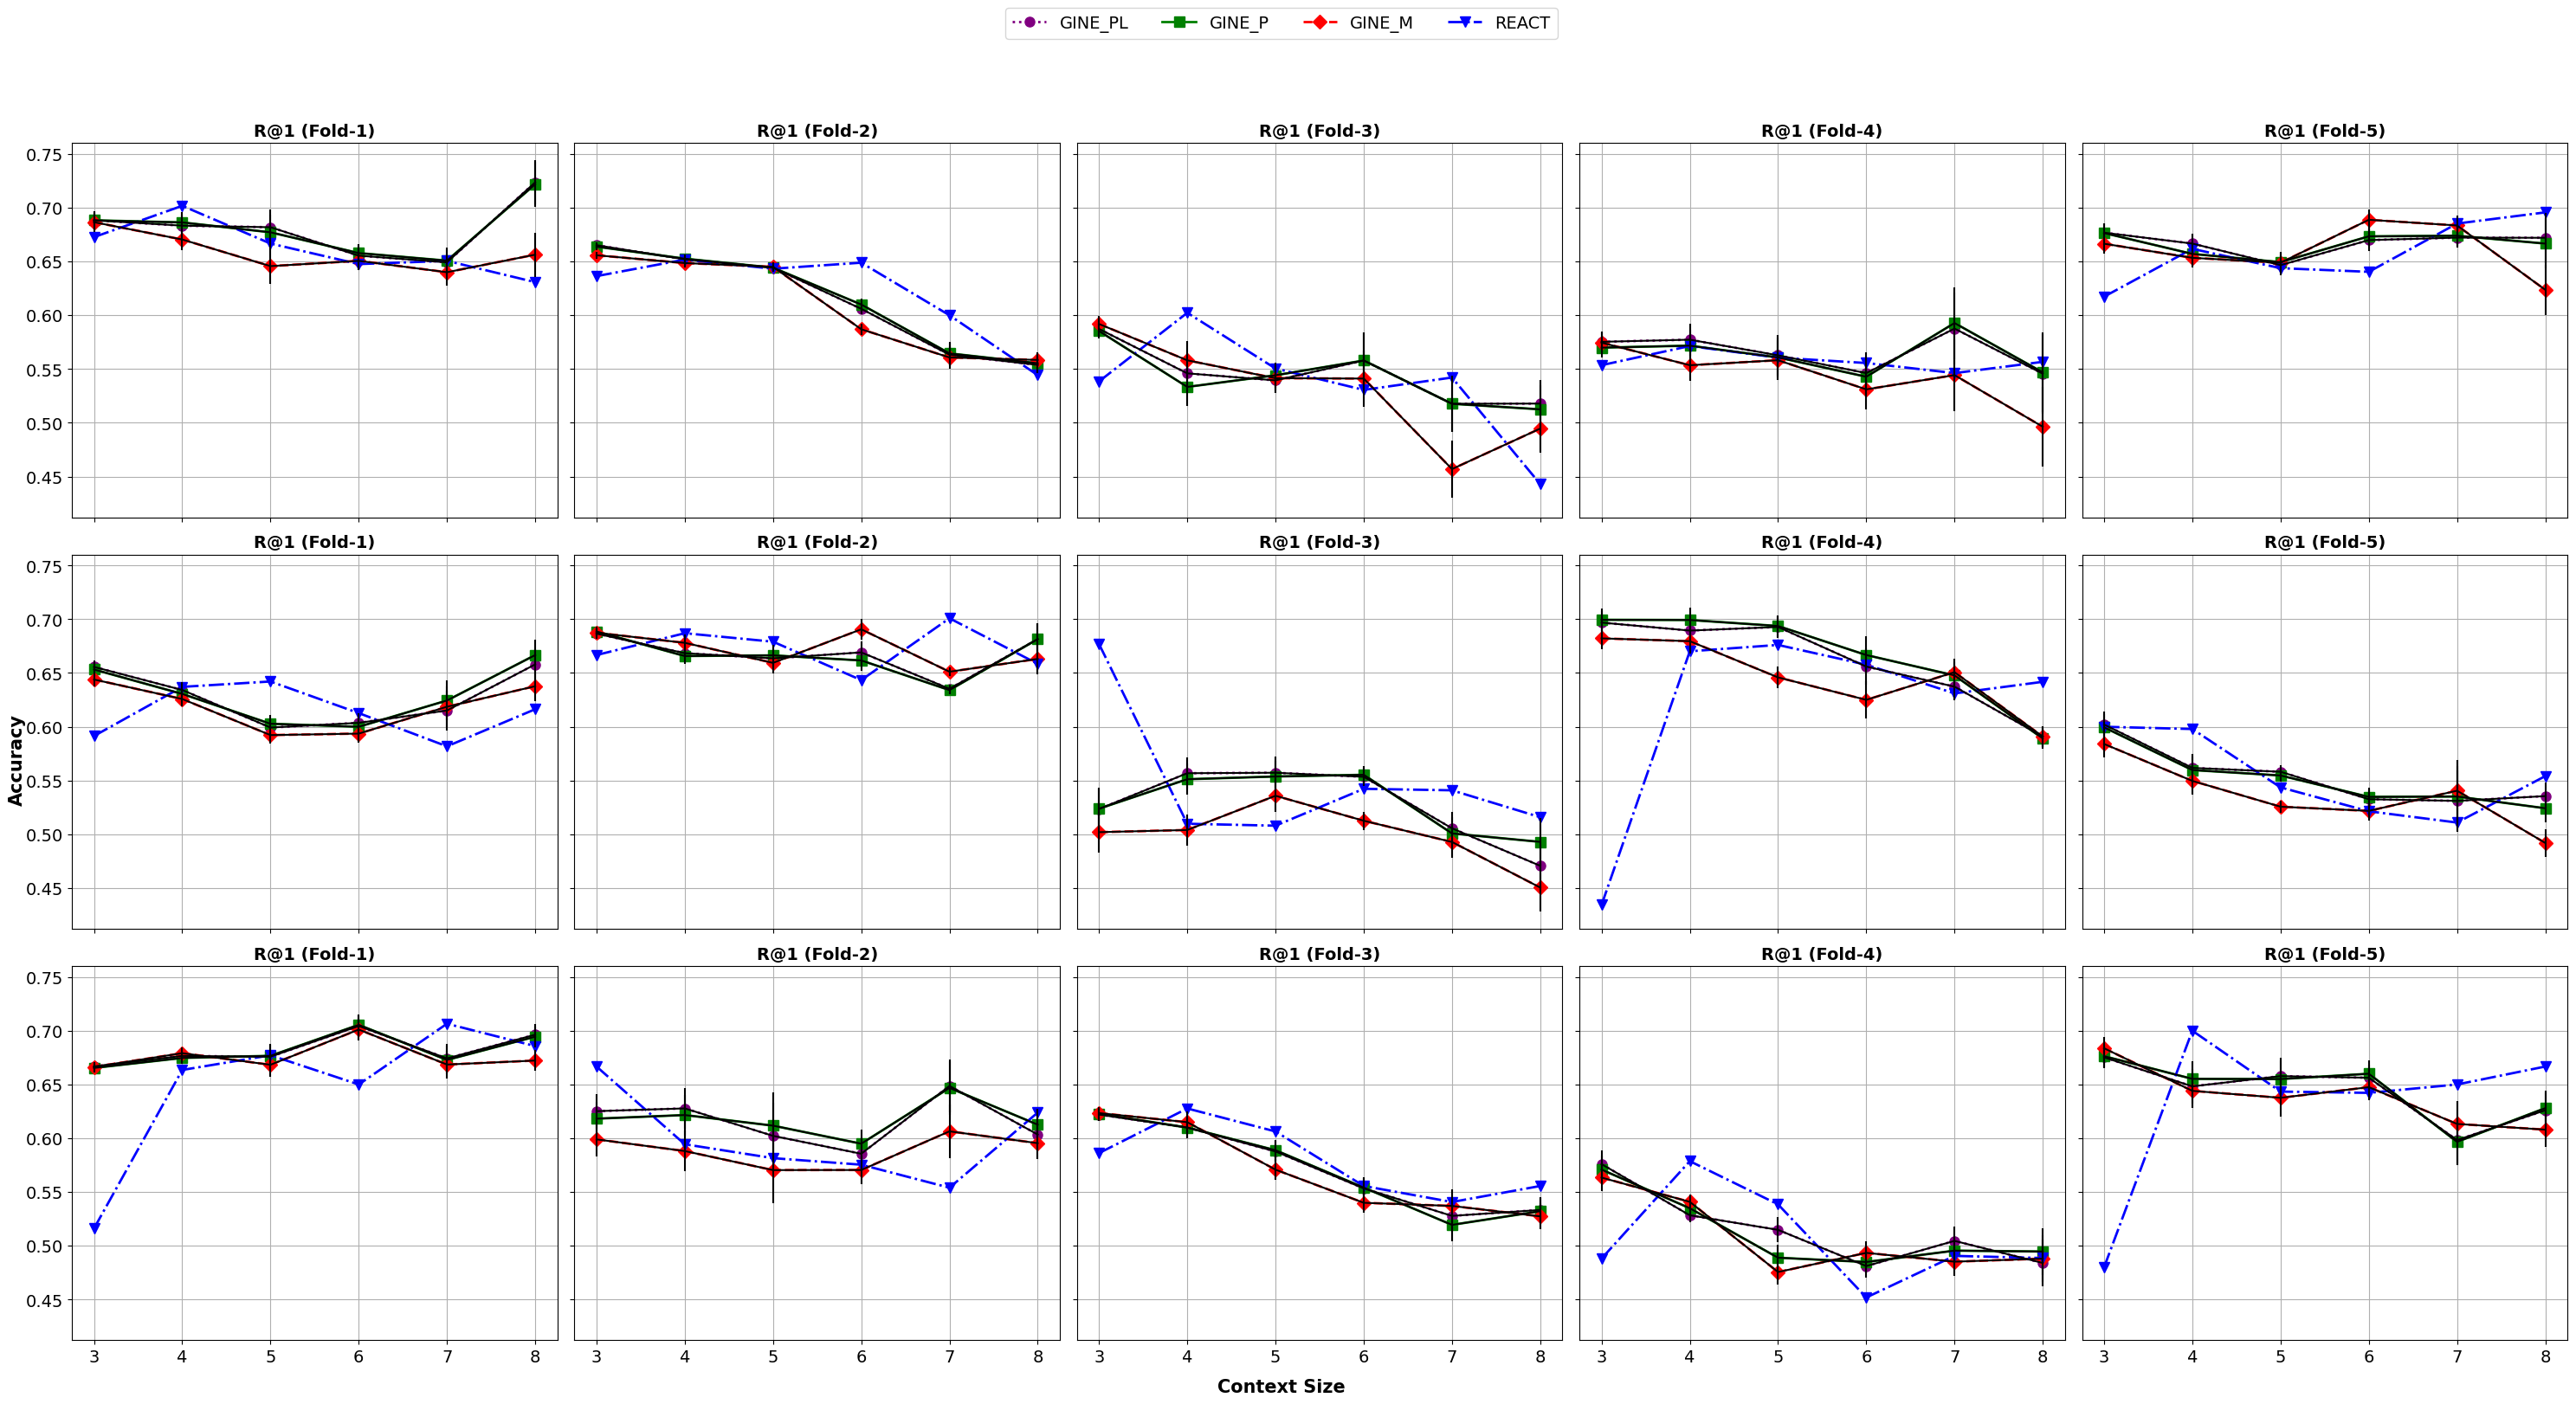

In [24]:
plt.close("all")
fontsize = 14
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 
task = 'act'

figure, axis = plt.subplots(nrows=3 , ncols=5, sharex=True, sharey=True, figsize=(30, 15))
sizes = list(range(3, 9))

for i, seed in enumerate(seeds):
    for j, test_id in enumerate(range(5)):
        ted = {'ra3':[], 'mrr':[]}
        ginepl = {'ra3':[], 'std':[]}
        ginep = {'ra3':[], 'std':[]}
        ginem = {'ra3':[], 'std':[]}
        for main_size in sizes:
            ted_result = pickle.load(open(f'{data_path}/network_data/chunk_ted_results/{seed}_{main_size}_{test_id}_unbiased.pickle', 'rb'))
            ted['ra3'].append(res['ra3'][0])

            res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{main_size}_{test_id}_unbiased_gine.pickle', 'rb'))
            ginepl['ra3'].append(statistics.mean(res['ra3']))
            ginepl['std'].append(statistics.stdev(res['ra3']))

            res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{main_size}_{test_id}_unbiased_gine_alone.pickle', 'rb'))
            ginep['ra3'].append(statistics.mean(res['ra3']))
            ginep['std'].append(statistics.stdev(res['ra3']))

            res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{main_size}_{test_id}_unbiased_gine_alone_single_context.pickle', 'rb'))
            ginem['ra3'].append(statistics.mean(res['ra3']))
            ginem['std'].append(statistics.stdev(res['ra3']))

        axis[i,j].plot(sizes, ginepl['ra3'], marker='o', markersize=8, linestyle=':', linewidth=2, color='purple', label='GINE_PL')
        axis[i,j].plot(sizes, ginep['ra3'], marker='s', markersize=8, linestyle='-', linewidth=2, color='green', label='GINE_P')
        axis[i,j].plot(sizes, ginem['ra3'], marker='D', markersize=8, linestyle='--', linewidth=2, color='red', label='GINE_M')
        axis[i,j].plot(sizes, ted['ra3'], marker='v', markersize=8, linestyle='-.', linewidth=2, color='blue', label='REACT')

        axis[i,j].errorbar(sizes, ginepl['ra3'], yerr=ginepl['std'], color="black")
        axis[i,j].errorbar(sizes, ginep['ra3'], yerr=ginepl['std'], color="black")
        axis[i,j].errorbar(sizes, ginem['ra3'], yerr=ginepl['std'], color="black")

        axis[i,j].grid()
        axis[i,j].set_title(f"{'R@1'} (Fold-{j+1})", fontsize=fontsize, fontweight='bold')
        axis[i,j].tick_params(labelsize=fontsize)
    
    # axis[2, 0].plot(sizes, overall["acc"][:,0], marker='o', markersize=8, linestyle=':', linewidth=2, color='purple', label='Min TRIAD')
    # axis[2, 0].plot(sizes, overall["acc"][:,1], marker='o', markersize=8, linestyle='-', linewidth=2, color='green', label='Avg TRIAD')
    # axis[2, 0].plot(sizes, overall["acc"][:,2], marker='o', markersize=8, linestyle='--', linewidth=2, color='red', label='Max TRIAD')
    # axis[2, 0].plot(sizes, overall["acc"][:,3], marker='v', markersize=8, linestyle='-.', linewidth=2, color='blue', label='Max REACT')
    # axis[2, 0].grid()
    # axis[2, 0].set_title('R@3 (Overall)', fontsize=fontsize, fontweight='bold')
    # axis[2, 0].tick_params(labelsize=fontsize)

# figure.suptitle(f'seed={seed}')
handles, labels = axis[0,0].get_legend_handles_labels()
lgd = figure.legend(handles, labels, loc='upper center', ncols=4, fontsize=fontsize, bbox_to_anchor=(0.5, 1.085))
lblx = figure.supxlabel('Context Size', fontsize=fontsize+1, fontweight='bold')
lbly = figure.supylabel('Accuracy', fontsize=fontsize+1, fontweight='bold', x=0.01)
plt.tight_layout()
# plt.savefig(f'{data_path}/network_data/result_plots/{task}_{seed}.eps', format='eps', bbox_extra_artists=(lgd, lblx, lbly), bbox_inches='tight')
plt.show()
    

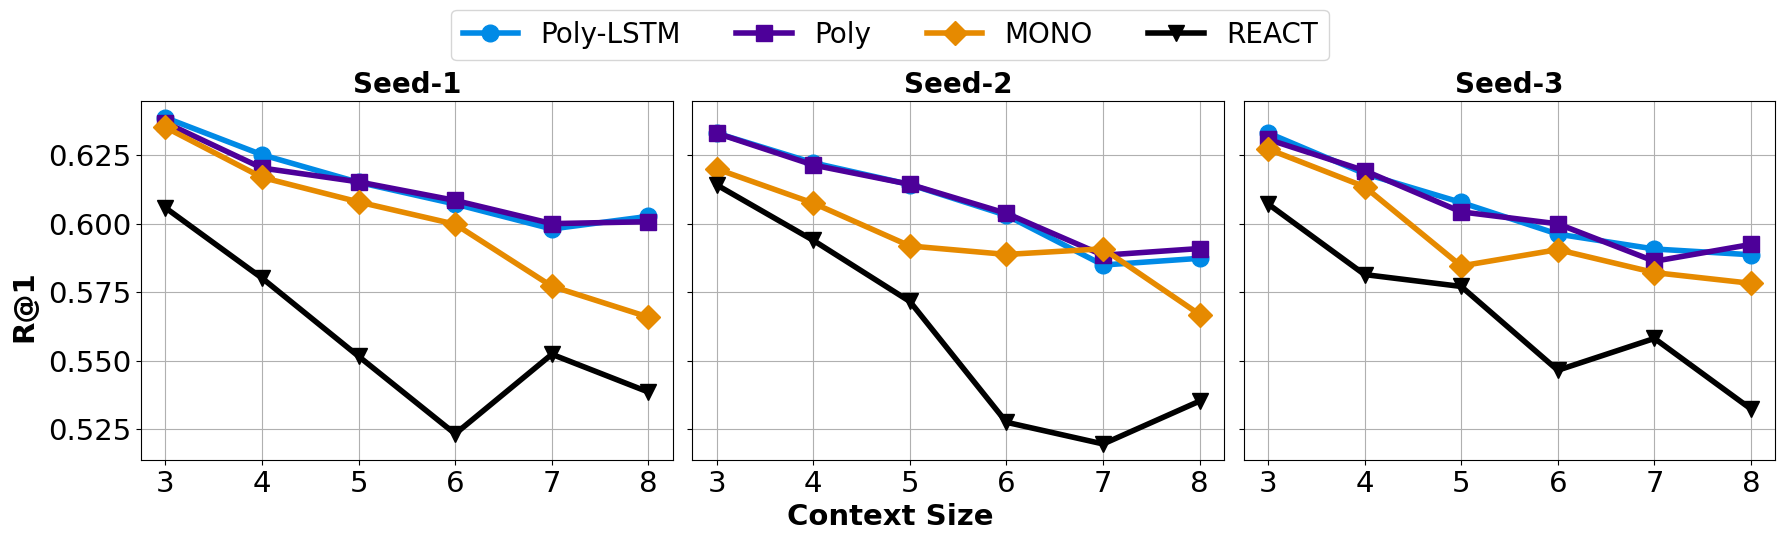

In [ ]:
plt.close("all")
fontsize = 20
markersize = 12
linewidth = 4
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 
task = 'act'

figure, axis = plt.subplots(nrows=1 , ncols=3, sharex=True, sharey=True, figsize=(18, 5))
sizes = list(range(3, 9))

for i, seed in enumerate(seeds):
    tedf = {'ra3':[], 'std':[]}
    gineplf = {'ra3':[], 'std':[]}
    ginepf = {'ra3':[], 'std':[]}
    ginemf = {'ra3':[], 'std':[]}
    for main_size in sizes:
        ted = {'ra3':[], 'mrr':[]}
        ginepl = {'ra3':[], 'mrr':[]}
        ginep = {'ra3':[], 'mrr':[]}
        ginem = {'ra3':[], 'mrr':[]}
        for test_id in range(5):
            res = pickle.load(open(f'{data_path}/network_data/chunk_ted_results/{seed}_{main_size}_{test_id}_unbiased.pickle', 'rb'))
            ted['ra3'].append(res['ra3'][0])

            res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{main_size}_{test_id}_unbiased_gine.pickle', 'rb'))
            ginepl['ra3'].extend(res['ra3'])

            res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{main_size}_{test_id}_unbiased_gine_alone.pickle', 'rb'))
            ginep['ra3'].extend(res['ra3'])

            res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{main_size}_{test_id}_unbiased_gine_alone_single_context.pickle', 'rb'))
            ginem['ra3'].extend(res['ra3'])

        tedf['ra3'].append(statistics.mean(ted['ra3']))
        tedf['std'].append(statistics.stdev(ted['ra3']))

        gineplf['ra3'].append(statistics.mean(ginepl['ra3']))
        gineplf['std'].append(statistics.stdev(ginepl['ra3']))

        ginepf['ra3'].append(statistics.mean(ginep['ra3']))
        ginepf['std'].append(statistics.stdev(ginep['ra3']))

        ginemf['ra3'].append(statistics.mean(ginem['ra3']))
        ginemf['std'].append(statistics.stdev(ginem['ra3']))

    axis[i].plot(sizes, gineplf['ra3'], marker='o', markersize=markersize, linestyle='-', linewidth=linewidth, color='#008ae6', label='Poly-LSTM')
    axis[i].plot(sizes, ginepf['ra3'], marker='s', markersize=markersize, linestyle='-', linewidth=linewidth, color='#4d0099', label='Poly')
    axis[i].plot(sizes, ginemf['ra3'], marker='D', markersize=markersize, linestyle='-', linewidth=linewidth, color='#e68a00', label='MONO')
    axis[i].plot(sizes, tedf['ra3'], marker='v', markersize=markersize, linestyle='-', linewidth=linewidth, color='black', label='REACT')

    # axis[i].errorbar(sizes, gineplf['ra3'], yerr=gineplf['std'], color="black")
    # axis[i].errorbar(sizes, ginepf['ra3'], yerr=ginepf['std'], color="black")
    # axis[i].errorbar(sizes, ginemf['ra3'], yerr=ginemf['std'], color="black")

    axis[i].grid()
    axis[i].set_title(f"Seed-{i+1}", fontsize=fontsize, fontweight='bold')
    # axis[0].set_ylabel('R@1', fontsize=fontsize+1, fontweight='bold', x=0.01)
    axis[i].tick_params(labelsize=fontsize+1)
    
    # axis[2, 0].plot(sizes, overall["acc"][:,0], marker='o', markersize=8, linestyle=':', linewidth=2, color='purple', label='Min TRIAD')
    # axis[2, 0].plot(sizes, overall["acc"][:,1], marker='o', markersize=8, linestyle='-', linewidth=2, color='green', label='Avg TRIAD')
    # axis[2, 0].plot(sizes, overall["acc"][:,2], marker='o', markersize=8, linestyle='--', linewidth=2, color='red', label='Max TRIAD')
    # axis[2, 0].plot(sizes, overall["acc"][:,3], marker='v', markersize=8, linestyle='-.', linewidth=2, color='blue', label='Max REACT')
    # axis[2, 0].grid()
    # axis[2, 0].set_title('R@3 (Overall)', fontsize=fontsize, fontweight='bold')
    # axis[2, 0].tick_params(labelsize=fontsize)

# figure.suptitle(f'seed={seed}')
handles, labels = axis[0].get_legend_handles_labels()
lgd = figure.legend(handles, labels, loc='upper center', ncols=4, fontsize=fontsize, bbox_to_anchor=(0.5, 1.12))
lblx = figure.supxlabel('Context Size', fontsize=fontsize+1, fontweight='bold', y=0.05)
lbly = figure.supylabel('R@1', fontsize=fontsize+1, fontweight='bold', x=0.011)
plt.tight_layout()
plt.savefig(f'{data_path}/network_data/paper_results/{task}.png', format='png', bbox_extra_artists=(lgd, lblx, lbly), bbox_inches='tight')
plt.show()
    

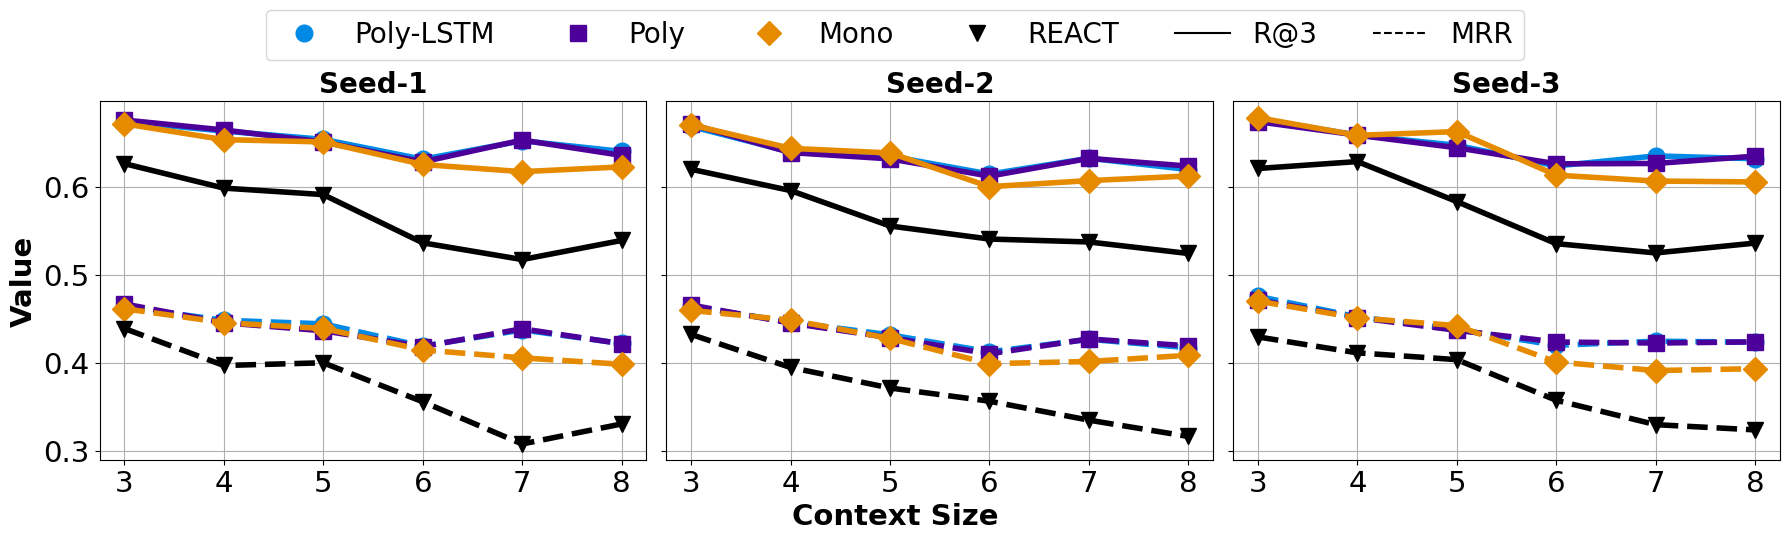

In [5]:
plt.close("all")
fontsize = 20
markersize = 12
linewidth = 4
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

tasks = ['act', 'col', 'tg']
task = 1

figure, axis = plt.subplots(nrows=1 , ncols=3, sharex=True, sharey=True, figsize=(18, 5))
sizes = list(range(3, 9))

for i, seed in enumerate(seeds):
    tedf = {'ra3':[], 'mrr':[], 'std':[]}
    gineplf = {'ra3':[], 'mrr':[], 'std':[]}
    ginepf = {'ra3':[], 'mrr':[], 'std':[]}
    ginemf = {'ra3':[], 'mrr':[], 'std':[]}
    for main_size in sizes:
        ted = {'ra3':[], 'mrr':[]}
        ginepl = {'ra3':[], 'mrr':[]}
        ginep = {'ra3':[], 'mrr':[]}
        ginem = {'ra3':[], 'mrr':[]}
        for test_id in range(5):
            res = pickle.load(open(f'{data_path}/network_data/chunk_ted_results/{seed}_{main_size}_{test_id}_unbiased.pickle', 'rb'))
            ted['ra3'].append(res['ra3'][task])
            ted['mrr'].append(res['mrr'][task])

            res = pickle.load(open(f'{data_path}/network_data/model_stats/{tasks[task]}_{seed}_{main_size}_{test_id}_unbiased_gine.pickle', 'rb'))
            ginepl['ra3'].extend(res['ra3'])
            ginepl['mrr'].extend(res['mrr'])

            res = pickle.load(open(f'{data_path}/network_data/model_stats/{tasks[task]}_{seed}_{main_size}_{test_id}_unbiased_gine_alone.pickle', 'rb'))
            ginep['ra3'].extend(res['ra3'])
            ginep['mrr'].extend(res['mrr'])

            res = pickle.load(open(f'{data_path}/network_data/model_stats/{tasks[task]}_{seed}_{main_size}_{test_id}_unbiased_gine_alone_single_context.pickle', 'rb'))
            ginem['ra3'].extend(res['ra3'])
            ginem['mrr'].extend(res['mrr'])

        tedf['ra3'].append(statistics.mean(ted['ra3']))
        tedf['mrr'].append(statistics.mean(ted['mrr']))
        tedf['std'].append(statistics.stdev(ted['ra3']))

        gineplf['ra3'].append(statistics.mean(ginepl['ra3']))
        gineplf['mrr'].append(statistics.mean(ginepl['mrr']))
        gineplf['std'].append(statistics.stdev(ginepl['ra3']))

        ginepf['ra3'].append(statistics.mean(ginep['ra3']))
        ginepf['mrr'].append(statistics.mean(ginep['mrr']))
        ginepf['std'].append(statistics.stdev(ginep['ra3']))

        ginemf['ra3'].append(statistics.mean(ginem['ra3']))
        ginemf['mrr'].append(statistics.mean(ginem['mrr']))
        ginemf['std'].append(statistics.stdev(ginem['ra3']))

    linestyle = ['-', '--']
    for j, ms in enumerate(['ra3', 'mrr']):
        axis[i].plot(sizes, gineplf[ms], marker='o', markersize=markersize, linestyle=linestyle[j], linewidth=linewidth, color='#008ae6', label='Poly-LSTM')
        axis[i].plot(sizes, ginepf[ms], marker='s', markersize=markersize, linestyle=linestyle[j], linewidth=linewidth, color='#4d0099', label='Poly')
        axis[i].plot(sizes, ginemf[ms], marker='D', markersize=markersize, linestyle=linestyle[j], linewidth=linewidth, color='#e68a00', label='Mono')
        axis[i].plot(sizes, tedf[ms], marker='v', markersize=markersize, linestyle=linestyle[j], linewidth=linewidth, color='black', label='REACT')
    
    axis[i].grid()

    # axis[i].errorbar(sizes, gineplf['ra3'], yerr=gineplf['std'], color="black")
    # axis[i].errorbar(sizes, ginepf['ra3'], yerr=ginepf['std'], color="black")
    # axis[i].errorbar(sizes, ginemf['ra3'], yerr=ginemf['std'], color="black")

    axis[i].set_title(f"Seed-{i+1}", fontsize=fontsize, fontweight='bold')
    axis[0].set_ylabel('Value', fontsize=fontsize+1, fontweight='bold', x=0.01)
    # axis[1,i].set_title(f"{'MRR'} (Seed-{i+1})", fontsize=fontsize, fontweight='bold')
    # axis[1,0].set_ylabel('MRR', fontsize=fontsize+1, fontweight='bold', x=0.01)
    axis[i].tick_params(labelsize=fontsize+1)
    
    # axis[2, 0].plot(sizes, overall["acc"][:,0], marker='o', markersize=8, linestyle=':', linewidth=2, color='purple', label='Min TRIAD')
    # axis[2, 0].plot(sizes, overall["acc"][:,1], marker='o', markersize=8, linestyle='-', linewidth=2, color='green', label='Avg TRIAD')
    # axis[2, 0].plot(sizes, overall["acc"][:,2], marker='o', markersize=8, linestyle='--', linewidth=2, color='red', label='Max TRIAD')
    # axis[2, 0].plot(sizes, overall["acc"][:,3], marker='v', markersize=8, linestyle='-.', linewidth=2, color='blue', label='Max REACT')
    # axis[2, 0].grid()
    # axis[2, 0].set_title('R@3 (Overall)', fontsize=fontsize, fontweight='bold')
    # axis[2, 0].tick_params(labelsize=fontsize)

# figure.suptitle(f'seed={seed}')
# handles, labels = axis[0].get_legend_handles_labels()
polylstm = mlines.Line2D([], [], marker='o', linestyle='None', markersize=markersize, color='#008ae6', label='Poly-LSTM')
poly = mlines.Line2D([], [], marker='s', linestyle='None', markersize=markersize, color='#4d0099', label='Poly')
mono = mlines.Line2D([], [], marker='D', linestyle='None', markersize=markersize, color='#e68a00', label='Mono')
react = mlines.Line2D([], [], marker='v', linestyle='None', markersize=markersize, color='black', label='REACT')
ra3_line = mlines.Line2D([], [], marker='None', linestyle='-', markersize=markersize, color='black', label='R@3')
mrr_line = mlines.Line2D([], [], marker='None', linestyle='--', markersize=markersize, color='black', label='MRR')

handles = [polylstm, poly, mono, react, ra3_line, mrr_line]
labels = ['Poly-LSTM', 'Poly', 'Mono', 'REACT', 'R@3', 'MRR']
lgd = figure.legend(handles, labels, loc='upper center', ncols=6, fontsize=fontsize, bbox_to_anchor=(0.5, 1.12))
lblx = figure.supxlabel('Context Size', fontsize=fontsize+1, fontweight='bold', y=0.05)
# lbly = figure.supylabel('Accuracy', fontsize=fontsize+1, fontweight='bold', x=0.01)
plt.tight_layout()
plt.savefig(f'{data_path}/network_data/paper_results/{tasks[task]}.png', format='png', bbox_extra_artists=(lgd, lblx, lbly), bbox_inches='tight')
plt.show()
    

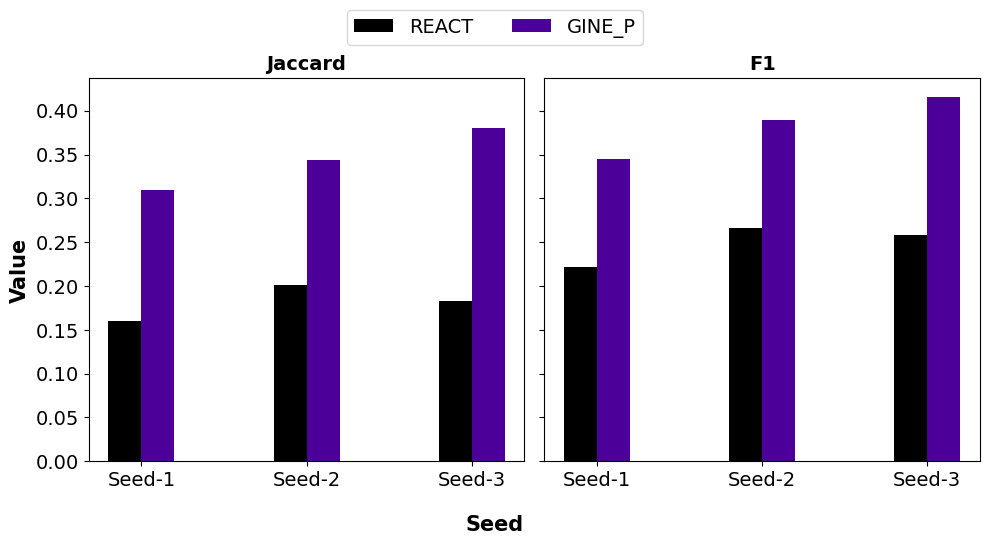

In [59]:
plt.close("all")
fontsize = 14
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

figure, axis = plt.subplots(nrows=1 , ncols=2, sharex=True, sharey=True, figsize=(10, 5))
main_size = 3
x_ax = np.array(list(range(1, 4)))
x_ticks = ['Seed-1', 'Seed-2', 'Seed-3']

tedf = {'jaccard':[], 'f1':[], 'std':[]}
ginef = {'jaccard':[], 'f1':[], 'std':[]}

for seed in seeds:
    ted = {'jaccard':[], 'f1':[]}
    gine = {'jaccard':[], 'f1':[]}
    for test_id in range(5):
        res = pickle.load(open(f'{data_path}/network_data/chunk_ted_results/{seed}_{main_size}_{test_id}_unbiased_agg.pickle', 'rb'))
        ted['jaccard'].append(res['jaccard'])
        ted['f1'].append(res['f1'])

        res = pickle.load(open(f'{data_path}/network_data/model_stats/{seed}_{main_size}_{test_id}_unbiased_gine_aggs.pickle', 'rb'))
        gine['jaccard'].extend(res['jaccard'])
        gine['f1'].extend(res['f1'])

    tedf['jaccard'].append(statistics.mean(ted['jaccard']))
    tedf['f1'].append(statistics.mean(ted['f1']))
    tedf['std'].append(statistics.stdev(ted['jaccard']))

    ginef['jaccard'].append(statistics.mean(gine['jaccard']))
    ginef['f1'].append(statistics.mean(gine['f1']))
    ginef['std'].append(statistics.stdev(gine['jaccard']))

titles = ['Jaccard', 'F1']
for i, ms in enumerate(['jaccard', 'f1']):
    axis[i].bar(x_ax - 0.1, tedf[ms], 0.2, color='black', label='REACT')
    axis[i].bar(x_ax + 0.1, ginef[ms], 0.2, color='#4d0099', label='GINE_P')
    # axis[i].grid()
    axis[i].set_title(f"{titles[i]}", fontsize=fontsize, fontweight='bold')
    axis[i].set_xticks(x_ax, x_ticks) 
    axis[i].tick_params(labelsize=fontsize)

# axis[i].errorbar(sizes, gineplf['jaccard'], yerr=gineplf['std'], color="black")
# axis[i].errorbar(sizes, ginepf['jaccard'], yerr=ginepf['std'], color="black")
# axis[i].errorbar(sizes, ginemf['jaccard'], yerr=ginemf['std'], color="black")

# axis[0,i].set_title(f"Seed-{i+1}", fontsize=fontsize, fontweight='bold')
axis[0].set_ylabel('Value', fontsize=fontsize+1, fontweight='bold', x=0.01)
# axis[1,i].set_title(f"{'f1'} (Seed-{i+1})", fontsize=fontsize, fontweight='bold')
# axis[1].set_ylabel('F1', fontsize=fontsize+1, fontweight='bold', x=0.01)


# axis[2, 0].plot(sizes, overall["acc"][:,0], marker='o', markersize=8, linestyle=':', linewidth=2, color='purple', label='Min TRIAD')
# axis[2, 0].plot(sizes, overall["acc"][:,1], marker='o', markersize=8, linestyle='-', linewidth=2, color='green', label='Avg TRIAD')
# axis[2, 0].plot(sizes, overall["acc"][:,2], marker='o', markersize=8, linestyle='--', linewidth=2, color='red', label='Max TRIAD')
# axis[2, 0].plot(sizes, overall["acc"][:,3], marker='v', markersize=8, linestyle='-.', linewidth=2, color='blue', label='Max REACT')
# axis[2, 0].grid()
# axis[2, 0].set_title('R@3 (Overall)', fontsize=fontsize, fontweight='bold')
# axis[2, 0].tick_params(labelsize=fontsize)

# figure.suptitle(f'seed={seed}')
handles, labels = axis[0].get_legend_handles_labels()
lgd = figure.legend(handles, labels, loc='upper center', ncols=4, fontsize=fontsize, bbox_to_anchor=(0.5, 1.08))
lblx = figure.supxlabel('Seed', fontsize=fontsize+1, fontweight='bold')
# lbly = figure.supylabel('Accuracy', fontsize=fontsize+1, fontweight='bold', x=0.01)
plt.tight_layout()
plt.savefig(f'{data_path}/network_data/paper_results/aggs.png', format='png', bbox_extra_artists=(lgd, lblx, lbly), bbox_inches='tight')
plt.show()
    

In [ ]:
tasks = ['act', 'col', 'tg']
task = 2
sizes = list(range(8, 9))
for i, seed in enumerate(seeds):
    if i != 0:
        break
    tedf = {'ra3':[], 'mrr':[], 'ra3std':[], 'mrrstd':[]}
    # gineplf = {'ra3':[], 'mrr':[], 'ra3std':[], 'mrrstd':[]}
    ginepf = {'ra3':[], 'mrr':[], 'ra3std':[], 'mrrstd':[]}
    # ginemf = {'ra3':[], 'mrr':[], 'ra3std':[], 'mrrstd':[]}
    multif = {'ra3':[], 'mrr':[], 'ra3std':[], 'mrrstd':[]}
    # tedaf = {'jaccard':[], 'f1':[], 'jstd':[], 'fstd':[]}
    # gineaf = {'jaccard':[], 'f1':[], 'kstd':[], 'fstd':[]}

    for task 
    for main_size in sizes:
        ted = {'ra3':[], 'mrr':[]}
        # ginepl = {'ra3':[], 'mrr':[]}
        ginep = {'ra3':[], 'mrr':[]}
        # ginem = {'ra3':[], 'mrr':[]}
        multi = {'ra3':[], 'mrr':[]}
        # teda = {'jaccard':[], 'f1':[]}
        # ginea = {'jaccard':[], 'f1':[]}
        for test_id in range(5):
            res = pickle.load(open(f'{data_path}/network_data/chunk_ted_results/{seed}_{main_size}_{test_id}_unbiased.pickle', 'rb'))
            ted['ra3'].append(res['ra3'][task])
            ted['mrr'].append(res['mrr'][task])

            # res = pickle.load(open(f'{data_path}/network_data/model_stats/{tasks[task]}_{seed}_{main_size}_{test_id}_unbiased_gine.pickle', 'rb'))
            # ginepl['ra3'].extend(res['ra3'])
            # ginepl['mrr'].extend(res['mrr'])

            res = pickle.load(open(f'{data_path}/network_data/model_stats/{tasks[task]}_{seed}_{main_size}_{test_id}_unbiased_gine_alone.pickle', 'rb'))
            ginep['ra3'].extend(res['ra3'])
            ginep['mrr'].extend(res['mrr'])

            # res = pickle.load(open(f'{data_path}/network_data/model_stats/{tasks[task]}_{seed}_{main_size}_{test_id}_unbiased_gine_alone_single_context.pickle', 'rb'))
            # ginem['ra3'].extend(res['ra3'])
            # ginem['mrr'].extend(res['mrr'])

            res = pickle.load(open(f'{data_path}/network_data/model_stats/{tasks[task]}_{seed}_{main_size}_{test_id}_unbiased_gine_multi.pickle', 'rb'))
            multi['ra3'].extend(res['ra3'])
            multi['mrr'].extend(res['mrr'])

            
            # res = pickle.load(open(f'{data_path}/network_data/chunk_ted_results/{seed}_{main_size}_{test_id}_unbiased_agg.pickle', 'rb'))
            # ted['jaccard'].append(res['jaccard'])
            # ted['f1'].append(res['f1'])

            # res = pickle.load(open(f'{data_path}/network_data/model_stats/{seed}_{main_size}_{test_id}_unbiased_gine_aggs.pickle', 'rb'))
            # gine['jaccard'].extend(res['jaccard'])
            # gine['f1'].extend(res['f1'])

        tedf['ra3'].append(statistics.mean(ted['ra3']))
        tedf['mrr'].append(statistics.mean(ted['mrr']))
        tedf['ra3std'].append(statistics.stdev(ted['ra3']))
        tedf['mrrstd'].append(statistics.stdev(ted['mrr']))

        # gineplf['ra3'].append(statistics.mean(ginepl['ra3']))
        # gineplf['mrr'].append(statistics.mean(ginepl['mrr']))
        # gineplf['ra3std'].append(statistics.stdev(ginepl['ra3']))
        # gineplf['mrrstd'].append(statistics.stdev(ginepl['mrr']))

        ginepf['ra3'].append(statistics.mean(ginep['ra3']))
        ginepf['mrr'].append(statistics.mean(ginep['mrr']))
        ginepf['ra3std'].append(statistics.stdev(ginep['ra3']))
        ginepf['mrrstd'].append(statistics.stdev(ginep['mrr']))

        # ginemf['ra3'].append(statistics.mean(ginem['ra3']))
        # ginemf['mrr'].append(statistics.mean(ginem['mrr']))
        # ginemf['ra3std'].append(statistics.stdev(ginem['ra3']))
        # ginemf['mrrstd'].append(statistics.stdev(ginem['mrr']))

        multif['ra3'].append(statistics.mean(multi['ra3']))
        multif['mrr'].append(statistics.mean(multi['mrr']))
        multif['ra3std'].append(statistics.stdev(multi['ra3']))
        multif['mrrstd'].append(statistics.stdev(multi['mrr']))

    print("& REACT&","&".join([f'\({round(x, 3)}_{"{"}{round(y, 3)}{"}"}\)' for x,y in zip(tedf['ra3'], tedf['ra3std'])]), " \\\\")
    print(f"Seed-{i+1}& Naive&","&".join([f'\({round(x, 3)}_{"{"}{round(y, 3)}{"}"}\)' for x,y in zip(multif['ra3'], multif['ra3std'])]), " \\\\")
    print("& Poly&","&".join([f'\(\mathbf{"{"}{round(x, 3)}_{"{"}{round(y, 3)}{"}"}{"}"}\)' for x,y in zip(ginepf['ra3'], ginepf['ra3std'])]), " \\\\")
    print("\midrule")

& REACT& \(0.328_{0.058}\)  \\
Seed-1& Naive& \(0.423_{0.069}\)  \\
& Poly& \(\mathbf{0.461_{0.072}}\)  \\
\midrule
& REACT& \(0.316_{0.034}\)  \\
Seed-2& Naive& \(0.411_{0.058}\)  \\
& Poly& \(\mathbf{0.454_{0.054}}\)  \\
\midrule
& REACT& \(0.384_{0.021}\)  \\
Seed-3& Naive& \(0.418_{0.043}\)  \\
& Poly& \(\mathbf{0.465_{0.066}}\)  \\
\midrule


In [2]:
for i in range(5):
    res = pickle.load(open(f'{data_path}/network_data/chunk_ted_results/{20250212}_{8}_{i}_unbiased.pickle', 'rb'))
    print(res['ra3'])
    print(res['mrr'])

[0.5455, 0.6182, 0.4]
[0.5455, 0.3727, 0.297]
[0.5385, 0.5231, 0.2462]
[0.5385, 0.3026, 0.141]
[0.4464, 0.5357, 0.3571]
[0.4464, 0.3423, 0.2173]
[0.5926, 0.5679, 0.3333]
[0.5926, 0.3457, 0.2819]
[0.5699, 0.4516, 0.3011]
[0.5699, 0.2921, 0.233]


In [42]:
res = pickle.load(open(f'{data_path}/network_data/chunk_ted_results/{20250212}_{3}_{0}_unbiased_agg.pickle', 'rb'))
res

{'jaccard': 0.0935, 'recall': 0.2708, 'precision': 0.1073, 'f1': 0.145}

In [21]:
for seed in [20250212, 20250214, 20250314]:
    j0, j1 = 0, 0
    f0, f1 = 0, 0
    for tid in range(5):
        res = pickle.load(open(f'{data_path}/network_data/chunk_ted_results/{seed}_{3}_{tid}_unbiased_agg.pickle', 'rb'))
        j0 += res['jaccard']
        f0 += res['f1']
        res = pickle.load(open(f'{data_path}/network_data/model_stats/{seed}_{3}_{tid}_unbiased_gine_aggs.pickle', 'rb'))
        j1 += sum(res['jaccard']) / len(res['jaccard'])
        f1 += sum(res['f1']) / len(res['f1'])
    print(j0/5, j1/5, f0/5, f1/5)
    print('----------------------')

0.16014000000000003 0.30985 0.22157999999999997 0.34453200000000006
----------------------
0.20076 0.344034 0.26638 0.38944
----------------------
0.18312 0.37982 0.25802 0.41612400000000005
----------------------


In [ ]:
res = pickle.load(open(f'{data_path}/network_data/chunk_ted_results/{20250212}_{3}_{3}_unbiased.pickle', 'rb'))
res

In [ ]:

for tid in range(5):
    res = pickle.load(open(f'{data_path}/network_data/model_stats/{"act"}_{20250212}_{3}_{tid}_unbiased_gine.pickle', 'rb'))
    print(sum(res['ra3'])/10)

0.68832
0.6651800000000001
0.58727
0.5753
0.6768200000000001


In [70]:
res = pickle.load(open(f'{data_path}/network_data/model_stats/col_{20250212}_{8}_{4}_unbiased_gine.pickle', 'rb'))
res

{'ra3': [0.5269,
  0.5591,
  0.5269,
  0.5484,
  0.5484,
  0.5484,
  0.5591,
  0.5484,
  0.5591,
  0.5269],
 'mrr': [0.3351,
  0.3441,
  0.3423,
  0.3459,
  0.3477,
  0.3584,
  0.353,
  0.3351,
  0.3459,
  0.3423],
 'trt': [1.5606593783696492,
  1.5468486388524374,
  1.5378086098035177,
  1.540033633708954,
  1.5397792156537373,
  1.542109351158142,
  1.5463071759541829,
  1.5454601605733236,
  1.5446711460749307,
  1.544955141544342],
 'tet': [0.0041869781008758,
  0.004112907113994748,
  0.004070829396606773,
  0.004067903975004791,
  0.004057162166923606,
  0.004059316112149146,
  0.004067170568691787,
  0.004064160452948677,
  0.0040551441971973705,
  0.004064099711756552]}

In [4]:
for seed in [20250212, 20250214, 20250314]:
    for task in ['col']: #['act', 'col', 'tg']:
        for size in range(3, 9):
            m0, m1, m2, m3, m4, m5 = 0, 0, 0, 0, 0, 0
            for tid in range(5):
                res = pickle.load(open(f'{data_path}/network_data/chunk_ted_results/{seed}_{size}_{tid}_unbiased.pickle', 'rb'))
                m0 += res['ra3'][1]
                # print(res['ra3'][0])
                res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_{tid}_unbiased_gine.pickle', 'rb'))
                m1 += sum(res['ra3']) / 10
                # print(res.keys())
                res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_{tid}_unbiased_gine_alone.pickle', 'rb'))
                m2 += sum(res['ra3']) / 10
                res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_{tid}_unbiased_gine_alone_single_context.pickle', 'rb'))
                m3 += sum(res['ra3']) / 10
                res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_{tid}_unbiased_gine_multi.pickle', 'rb'))
                m4 += sum(res['ra3']) / 10
                res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_{tid}_unbiased_gine_poly_multi.pickle', 'rb'))
                m5 += sum(res['ra3']) / 10
            print(m0/5, m1/5, m2/5, m3/5, m4/5, m5/5)
        print('--------------')
        

0.62648 0.674084 0.6759920000000001 0.6716199999999999 0.668766 0.668654
0.59872 0.6634479999999999 0.664654 0.653678 0.6507539999999998 0.6476859999999999
0.59134 0.65404 0.651048 0.6511340000000001 0.645892 0.6362140000000001
0.53664 0.6314439999999999 0.6284639999999999 0.625516 0.6135760000000001 0.6164160000000001
0.51764 0.6524300000000001 0.6532 0.617364 0.6101780000000001 0.636592
0.5393 0.640384 0.635834 0.622774 0.5915819999999999 0.6082280000000001
--------------
0.62008 0.668708 0.671108 0.6705340000000001 0.664426 0.6651619999999999
0.5959199999999999 0.639578 0.639 0.643842 0.652868 0.644134
0.5557000000000001 0.635078 0.6319060000000001 0.638566 0.6381159999999999 0.6258779999999999
0.5409200000000001 0.614644 0.612294 0.600354 0.608204 0.591446
0.5376 0.632584 0.632412 0.607196 0.6046819999999999 0.6053900000000001
0.5245200000000001 0.6197579999999999 0.6237079999999999 0.612474 0.6040880000000001 0.617642
--------------
0.62096 0.677268 0.6740579999999999 0.67866 0.68

In [5]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [6]:
size = 8

for seed in [20250212, 20250214, 20250314]:
    for tid in range(5):
        print(f'------------------------------------------react-{seed}-{tid}--------------------------------------------')
        res = pickle.load(open(f'{data_path}/network_data/chunk_ted_results/{seed}_{size}_{tid}_unbiased.pickle', 'rb'))
        print(res)

        # res = pickle.load(open(f'{data_path}/network_data/chunk_ted_results/{seed}_{size}_{tid}_unbiased_inverse.pickle', 'rb'))
        # print(res)

        for task in ['col', 'tg']:
            try:
                print(f'------------------------------------------{task}-{seed}-{tid}--------------------------------------------')
                # res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_gine_seq.pickle', 'rb'))
                # print(res)
                # res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_{tid}_gine_seq_inverse.pickle', 'rb'))
                # print(res)
                res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_gine_own.pickle', 'rb'))
                print(res)
                # res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_hot_lstm.pickle', 'rb'))
                # print(res)
                # res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_gine_mono_context.pickle', 'rb'))
                # print(res)
                # res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_{tid}_unbiased_gine_multi.pickle', 'rb'))
                # print(res)
                res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_{tid}_unbiased_gine_alone_single_context.pickle', 'rb'))
                print(res)
            except:
                print(f'{bcolors.WARNING}Skipping {task}_{seed}_{size}_[{tid}]{bcolors.ENDC}')
                continue
    
    print('\n++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')

------------------------------------------react-20250212-0--------------------------------------------
{'ra3': [0.5455, 0.6182, 0.4], 'mrr': [0.5455, 0.3727, 0.297]}
------------------------------------------col-20250212-0--------------------------------------------
{'ra3': [0.6545, 0.6727, 0.6909, 0.6727, 0.6545], 'mrr': [0.4667, 0.4333, 0.4485, 0.4515, 0.4333]}
{'ra3': [0.6727, 0.6909, 0.6909, 0.6727, 0.6909, 0.7091, 0.6909, 0.6909, 0.6545, 0.7091], 'mrr': [0.4576, 0.4424, 0.4485, 0.4242, 0.4697, 0.4606, 0.4273, 0.4273, 0.4091, 0.4364], 'trt': [0.5941090965270996, 0.5957973607381185, 0.5961728747685751, 0.5974799839655558, 0.5984846146901449, 0.5996552236874898, 0.5990271965662638, 0.6001461799939474, 0.6004001418749492, 0.6010993758837382], 'tet': [0.0013718841581633597, 0.0013668003949252043, 0.0013698384834058357, 0.0013675316174825035, 0.0013662108219031134, 0.001367588115460945, 0.001369125713001598, 0.0013654674472230854, 0.0013698002497355144, 0.0013721774130156547]}
---------

In [ ]:
task = 'act'

entry = "&"

for seed in [20250212, 20250214, 20250314]:
    for size in range(3, 9):
        actr, actm = 0, 0
        colr, colm = 0, 0
        tgr, tgm = 0, 0

        ours1 = {'actr':0, 'colr':0, 'tgr':0, 'actm':0, 'colm':0, 'tgm':0}
        ours2 = {'actr':0, 'colr':0, 'tgr':0, 'actm':0, 'colm':0, 'tgm':0}
        for tid in range(5):
            # print(f'------------------------------------------react-{seed}-{tid}--------------------------------------------')
            res = pickle.load(open(f'{data_path}/network_data/chunk_ted_results/{seed}_{size}_{tid}_unbiased.pickle', 'rb'))
            # print(res)
            actr += res['ra3'][0]
            actm += res['mrr'][0]

            colr += res['ra3'][1]
            colm += res['mrr'][1]

            # tgr += res['ra3'][2]
            # tgm += res['mrr'][2]

            # res = pickle.load(open(f'{data_path}/network_data/chunk_ted_results/{seed}_{size}_{tid}_unbiased_inverse.pickle', 'rb'))
            # print(res)

            # try:
                # print(f'------------------------------------------{task}-{seed}-{tid}--------------------------------------------')
                # res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_gine_seq.pickle', 'rb'))
                # print(res)
                # ours1[f'{task}r'] += sum(res['ra3']) / len(res['ra3'])
                # ours1[f'{task}m'] += sum(res['mrr']) / len(res['mrr'])
                # res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_{tid}_gine_seq_inverse.pickle', 'rb'))
                # print(res)
                # res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_gine_own.pickle', 'rb'))
                # # print(res)
                # ours2[f'{task}r'] += sum(res['ra3']) / len(res['ra3'])
                # ours2[f'{task}m'] += sum(res['mrr']) / len(res['mrr'])
                # res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_hot_lstm.pickle', 'rb'))
                # print(res)
                # res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_gine_mono_context.pickle', 'rb'))
                # print(res)
                # res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_{tid}_unbiased_gine_multi.pickle', 'rb'))
                # print(res)
                # res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_{tid}_unbiased_gine_alone_single_context.pickle', 'rb'))
                # print(res)
            # except:
            #     continue
        
        print(f'\n++++++++++++++++++++++++++++++++++++++++++++++++++++{seed}-{size}++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
        
        react_ra3, ours2_ra3 = round(actr/5, 4), round(ours2['actr']/5, 4)
        print(round(react_ra3, 2), round(ours2_ra3, 2))
        actr_gain = round(((ours2_ra3 - react_ra3) / react_ra3) * 100, 2)

        react_mrr, ours2_mrr = round(actm/5, 4), round(ours2['actm']/5, 4)
        print(round(react_mrr, 2), round(ours2_mrr, 2))
        actm_gain = round(((ours2_mrr - react_mrr) / react_mrr) * 100, 2)

        print(f'-----------------------------------------------------------------------------------------------------------------------------')

        react_ra3, ours2_ra3 = round(colr/5, 4), round(ours2['colr']/5, 4)
        print(round(react_ra3, 2), round(ours2_ra3, 2))
        colr_gain = round(((ours2_ra3 - react_ra3) / react_ra3) * 100, 2)

        react_mrr, ours2_mrr = round(colm/5, 4), round(ours2['colm']/5, 4)
        print(round(react_mrr, 2), round(ours2_mrr, 2))
        colm_gain = round(((ours2_mrr - react_mrr) / react_mrr) * 100, 2)

        print(actr_gain, colr_gain)
        print(actm_gain, colm_gain)

        


++++++++++++++++++++++++++++++++++++++++++++++++++++20250314-3++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0.61 0.64
0.61 0.64
-----------------------------------------------------------------------------------------------------------------------------
0.62 0.7
0.43 0.49
5.67 12.08
5.67 13.4

++++++++++++++++++++++++++++++++++++++++++++++++++++20250314-4++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0.58 0.63
0.58 0.63
-----------------------------------------------------------------------------------------------------------------------------
0.63 0.68
0.41 0.47
7.96 8.09
7.96 14.57

++++++++++++++++++++++++++++++++++++++++++++++++++++20250314-5++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0.58 0.61
0.58 0.61
-----------------------------------------------------------------------------------------------------------------------------
0.58 0.67
0.4 0.45
6.38 14.93
6.38 12.1

++++++++++++++++++++++++++++++++++++++++++++++++++++20250314-6++++++++++++

In [3]:
task = 'col'

idx = None
if task == 'act':
    idx = 0
elif task == 'col':
    idx = 1
elif task == 'tg':
    idx = 2

file_postfix = ""

entry = "&"

ra3_gains = []
for seed in [20250212, 20250214, 20250314]:
    for size in range(3, 9):
        ra3_react, mrr_react = 0, 0
        ra3, mrr = 0, 0
        ra3_list, mrr_list = [], []

        for tid in range(5):
            # print(f'------------------------------------------react-{seed}-{tid}--------------------------------------------')

            try:
                res_react = pickle.load(open(f'{data_path}/network_data/chunk_ted_results/{seed}_{size}_{tid}_unbiased.pickle', 'rb'))
                ra3_react += res_react['ra3'][idx]
                mrr_react += res_react['mrr'][idx]

                # ra3_list.extend(res['ra3'])
                # mrr_list.extend(res['mrr'])

                res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_gine_own.pickle', 'rb'))
                ra3_list.extend(res['ra3'])
                mrr_list.extend(res['mrr'])
            except Exception as e:
                print(seed, size, tid)
                print(e)
        
        # print(f'\n++++++++++++++++++++++++++++++++++++++++++++++++++++{seed}-{size}++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
        
        # final_ra3 = int(round(ra3_react/5, 2) * 100)
        # final_mrr = int(round(mrr_react/5, 2) * 100)

        final_ra3 = ra3_react/5
        final_mrr = mrr_react/5

        ra3 = statistics.mean(ra3_list)
        mrr = statistics.mean(mrr_list)

        ra3_gain = round(((ra3 - final_ra3) / final_ra3) * 100, 2)
        ra3_gains.append(ra3_gain)

        # ra3_stdv = str(round(statistics.stdev(ra3_list), 2)).lstrip("0")
        # mrr_stdv = str(round(statistics.stdev(mrr_list), 2)).lstrip("0")

        # if task != 'act':
        #     entry += f" \\begin{{tabular}}[c]{{@{{}}l@{{}}}}$.{final_ra3}_{{{ra3_stdv}}}$\\\\ $.{final_mrr}_{{{mrr_stdv}}}$\end{{tabular}} &"
        # else:
        #     entry += f" $.{final_ra3}_{{{ra3_stdv}}}$ &"

# print(entry)    
print(min(ra3_gains), max(ra3_gains), statistics.mean(ra3_gains))

8.08 27.34 16.88611111111111


In [5]:
task = 'act'

idx = None
if task == 'act':
    idx = 0
elif task == 'col':
    idx = 1
elif task == 'tg':
    idx = 2

file_postfix = ""

entry = "&"

ra3_gains = []
for seed in [20250212, 20250214, 20250314]:
    for size in range(3, 9):
        ra3_base, mrr_base = [], []
        ra3_list, mrr_list = [], []

        for tid in range(5):
            # print(f'------------------------------------------react-{seed}-{tid}--------------------------------------------')

            try:
                res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_gine_seq.pickle', 'rb'))
                ra3_base.extend(res['ra3'])
                mrr_base.extend(res['mrr'])

                # ra3_list.extend(res['ra3'])
                # mrr_list.extend(res['mrr'])

                res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_gine_own.pickle', 'rb'))
                ra3_list.extend(res['ra3'])
                mrr_list.extend(res['mrr'])
            except Exception as e:
                print(seed, size, tid)
                print(e)
        
        # print(f'\n++++++++++++++++++++++++++++++++++++++++++++++++++++{seed}-{size}++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
        
        # final_ra3 = int(round(ra3_react/5, 2) * 100)
        # final_mrr = int(round(mrr_react/5, 2) * 100)

        final_ra3 = statistics.mean(ra3_base)
        final_mrr = statistics.mean(mrr_base)

        ra3 = statistics.mean(ra3_list)
        mrr = statistics.mean(mrr_list)

        ra3_gain = round(((ra3 - final_ra3) / final_ra3) * 100, 2)
        ra3_gains.append(ra3_gain)

        # ra3_stdv = str(round(statistics.stdev(ra3_list), 2)).lstrip("0")
        # mrr_stdv = str(round(statistics.stdev(mrr_list), 2)).lstrip("0")

        # if task != 'act':
        #     entry += f" \\begin{{tabular}}[c]{{@{{}}l@{{}}}}$.{final_ra3}_{{{ra3_stdv}}}$\\\\ $.{final_mrr}_{{{mrr_stdv}}}$\end{{tabular}} &"
        # else:
        #     entry += f" $.{final_ra3}_{{{ra3_stdv}}}$ &"

# print(entry)    
print(min(ra3_gains), max(ra3_gains))

1.66 11.43


In [2]:
task = 'tg'

idx = None
if task == 'act':
    idx = 0
elif task == 'col':
    idx = 1
elif task == 'tg':
    idx = 2

file_postfix = ""

entry = "&"

for seed in [20250212, 20250214, 20250314]:
    for size in range(3, 9):
        ra3_react, mrr_react = 0, 0
        ra3_list, mrr_list = [], []

        for tid in range(5):
            # print(f'------------------------------------------react-{seed}-{tid}--------------------------------------------')

            try:
                # res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_hot_lstm.pickle', 'rb'))
                # res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_gine_mono_context.pickle', 'rb'))
                res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_gine_seq.pickle', 'rb'))
                # res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_gine_own.pickle', 'rb'))
                # res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_{file_postfix}.pickle', 'rb'))

                ra3_list.extend(res['ra3'])
                mrr_list.extend(res['mrr'])
            except Exception as e:
                print(seed, size, tid)
                print(e)
        
        # print(f'\n++++++++++++++++++++++++++++++++++++++++++++++++++++{seed}-{size}++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
        
        # react_ra3 = int(round(ra3_react/5, 2) * 100)
        # react_mrr = int(round(mrr_react/5, 2) * 100)

        final_ra3 = int(round(statistics.mean(ra3_list), 2) * 100)
        final_mrr = int(round(statistics.mean(mrr_list), 2) * 100)

        ra3_stdv = str(round(statistics.stdev(ra3_list), 2)).lstrip("0")
        mrr_stdv = str(round(statistics.stdev(mrr_list), 2)).lstrip("0")

        if task != 'act':
            entry += f" \\begin{{tabular}}[c]{{@{{}}l@{{}}}}$.{final_ra3}_{{{ra3_stdv}}}$\\\\ $.{final_mrr}_{{{mrr_stdv}}}$\end{{tabular}} &"
            # entry += f" \\begin{{tabular}}[c]{{@{{}}l@{{}}}}$\\mathbf{{.{final_ra3}}}_{{{ra3_stdv}}}$\\\\ $\\mathbf{{.{final_mrr}}}_{{{mrr_stdv}}}$\end{{tabular}} &"
        else:
            entry += f" $.{final_ra3}_{{{ra3_stdv}}}$ &"

print(entry)    

& \begin{tabular}[c]{@{}l@{}}$.42_{.05}$\\ $.28_{.03}$\end{tabular} & \begin{tabular}[c]{@{}l@{}}$.40_{.04}$\\ $.27_{.03}$\end{tabular} & \begin{tabular}[c]{@{}l@{}}$.39_{.03}$\\ $.26_{.02}$\end{tabular} & \begin{tabular}[c]{@{}l@{}}$.37_{.03}$\\ $.25_{.01}$\end{tabular} & \begin{tabular}[c]{@{}l@{}}$.36_{.03}$\\ $.24_{.02}$\end{tabular} & \begin{tabular}[c]{@{}l@{}}$.38_{.04}$\\ $.25_{.02}$\end{tabular} & \begin{tabular}[c]{@{}l@{}}$.43_{.03}$\\ $.28_{.02}$\end{tabular} & \begin{tabular}[c]{@{}l@{}}$.41_{.03}$\\ $.27_{.02}$\end{tabular} & \begin{tabular}[c]{@{}l@{}}$.39_{.02}$\\ $.26_{.02}$\end{tabular} & \begin{tabular}[c]{@{}l@{}}$.36_{.02}$\\ $.25_{.02}$\end{tabular} & \begin{tabular}[c]{@{}l@{}}$.38_{.04}$\\ $.25_{.03}$\end{tabular} & \begin{tabular}[c]{@{}l@{}}$.39_{.03}$\\ $.27_{.03}$\end{tabular} & \begin{tabular}[c]{@{}l@{}}$.45_{.07}$\\ $.30_{.06}$\end{tabular} & \begin{tabular}[c]{@{}l@{}}$.42_{.07}$\\ $.28_{.06}$\end{tabular} & \begin{tabular}[c]{@{}l@{}}$.40_{.08}$\\ $.27_

In [37]:
task = 'act'

idx = None
if task == 'act':
    idx = 0
elif task == 'col':
    idx = 1
elif task == 'tg':
    idx = 2

file_postfix = ""

entry = "&"
gain_entry = "&"
ra3_gains = []
mrr_gains = []

for size in range(3, 9):
    ra3_react, mrr_react = [], []
    ra3_list, mrr_list = [], []
    for seed in [20250212, 20250214, 20250314]:
        for tid in range(5):
            # print(f'------------------------------------------react-{seed}-{tid}--------------------------------------------')

            try:
                # res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_hot_lstm.pickle', 'rb'))
                # res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_gine_mono_context.pickle', 'rb'))
                # res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_gine_seq.pickle', 'rb'))
                res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_gine_own.pickle', 'rb'))
                # res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{seed}_{size}_[{tid}]_{file_postfix}.pickle', 'rb'))

                ra3_list.extend(res['ra3'])
                mrr_list.extend(res['mrr'])

                res = pickle.load(open(f'{data_path}/network_data/chunk_ted_results/{seed}_{size}_{tid}_unbiased.pickle', 'rb'))
                ra3_react.append(res['ra3'][idx])
                mrr_react.append(res['mrr'][idx])
            except Exception as e:
                print(seed, size, tid)
                print(e)
        
    # print(f'\n++++++++++++++++++++++++++++++++++++++++++++++++++++{seed}-{size}++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    
    react_ra3 = int(round(statistics.mean(ra3_react), 2) * 100)
    react_mrr = int(round(statistics.mean(mrr_react), 2) * 100)

    final_ra3 = int(round(statistics.mean(ra3_list), 2) * 100)
    final_mrr = int(round(statistics.mean(mrr_list), 2) * 100)

    ra3_stdv = str(round(statistics.stdev(ra3_list), 2)).lstrip("0")
    mrr_stdv = str(round(statistics.stdev(mrr_list), 2)).lstrip("0")

    ra3_gain = round(((final_ra3 - react_ra3) / react_ra3) * 100, 2)
    mrr_gain = round(((final_mrr - react_mrr) / react_mrr) * 100, 2)

    ra3_gains.append(ra3_gain)
    mrr_gains.append(mrr_gain)

    if task != 'act':
        entry += f" \\begin{{tabular}}[c]{{@{{}}l@{{}}}}$.{final_ra3}_{{{ra3_stdv}}}$\\\\ $.{final_mrr}_{{{mrr_stdv}}}$\end{{tabular}} &\n"
        gain_entry += f" \\begin{{tabular}}[c]{{@{{}}l@{{}}}}${ra3_gain}\\%$\\\\ ${mrr_gain}\\%$\end{{tabular}} &\n"
        # entry += f" \\begin{{tabular}}[c]{{@{{}}l@{{}}}}$\\mathbf{{.{final_ra3}}}_{{{ra3_stdv}}}$\\\\ $\\mathbf{{.{final_mrr}}}_{{{mrr_stdv}}}$\end{{tabular}} &\n"
    else:
        entry += f" $.{final_ra3}_{{{ra3_stdv}}}$ &"
        gain_entry += f" ${ra3_gain}\\%$ &"

print(entry)
print()
print(gain_entry)    
print()
print(f'Min={min(ra3_gains)} Max={max(ra3_gains)} Avg={round(statistics.mean(ra3_gains), 2)} | Min={min(mrr_gains)} Max={max(mrr_gains)} Avg={round(statistics.mean(mrr_gains), 2)}')

& $.64_{.06}$ & $.63_{.05}$ & $.62_{.06}$ & $.62_{.06}$ & $.61_{.06}$ & $.63_{.07}$ &

& $4.92\%$ & $6.78\%$ & $10.71\%$ & $16.98\%$ & $12.96\%$ & $16.67\%$ &

Min=4.92 Max=16.98 Avg=11.5 | Min=4.92 Max=16.98 Avg=11.5


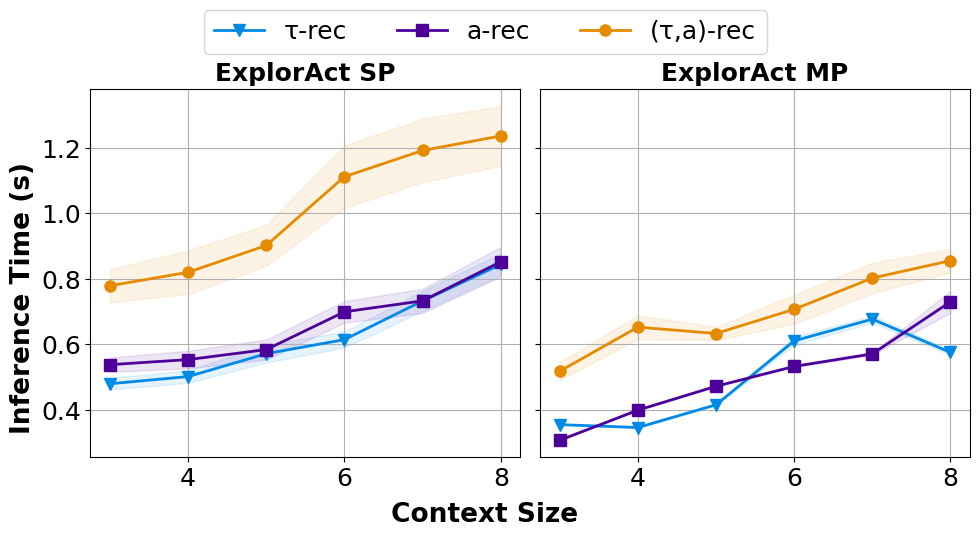

In [14]:
plt.close('all')

fontsize = 18
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

figure, axis = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10, 5))

tasks = ['act', 'col', 'tg']
colors = ['#008ae6', '#4d0099', '#e68a00']
markers = ['v', 's', 'o']

tau = u"\u03C4"
labels = [f"{tau}-rec", 'a-rec', f"({tau},a)-rec"]

titles = ['ExplorAct SP', 'ExplorAct MP']

for i, file_fix in enumerate(['seq', 'own']):
    times = {}
    for task in tasks:
        avg = []
        std = []
        for size in range(3, 9):
            res = pickle.load(open(f'{data_path}/network_data/model_stats/{task}_{size}_gine_{file_fix}_time.pickle', 'rb'))
            # print(res)
            avg.append(res['avg'] / 1e9)
            std.append(res['stdv'] / 1e9)
        times[task] = (np.array(avg), np.array(std))

    x = list(range(3, 9))
    for j, task in enumerate(tasks):
        axis[i].plot(x, times[task][0], marker=markers[j], markersize=8, linestyle='-', linewidth=2, color=colors[j], label=labels[j])
        axis[i].fill_between(x, times[task][0] - times[task][1], times[task][0] + times[task][1], color=colors[j], alpha=0.1)
        axis[i].grid(True)
        axis[i].set_title(titles[i], fontsize=fontsize, fontweight='bold')

handles, labels = axis[0].get_legend_handles_labels()
lgd = figure.legend(handles, labels, loc='upper center', ncols=4, fontsize=fontsize, bbox_to_anchor=(0.5, 1.1))
lblx = figure.supxlabel('Context Size', fontsize=fontsize+1, fontweight='bold', y=0.04)
lbly = figure.supylabel('Inference Time (s)', fontsize=fontsize+1, fontweight='bold', x=0.025)
plt.tight_layout()
plt.savefig(f'{data_path}/network_data/time_plots/inference_plot.pdf', format='pdf', bbox_extra_artists=(lgd, lblx, lbly), bbox_inches='tight')
plt.show()

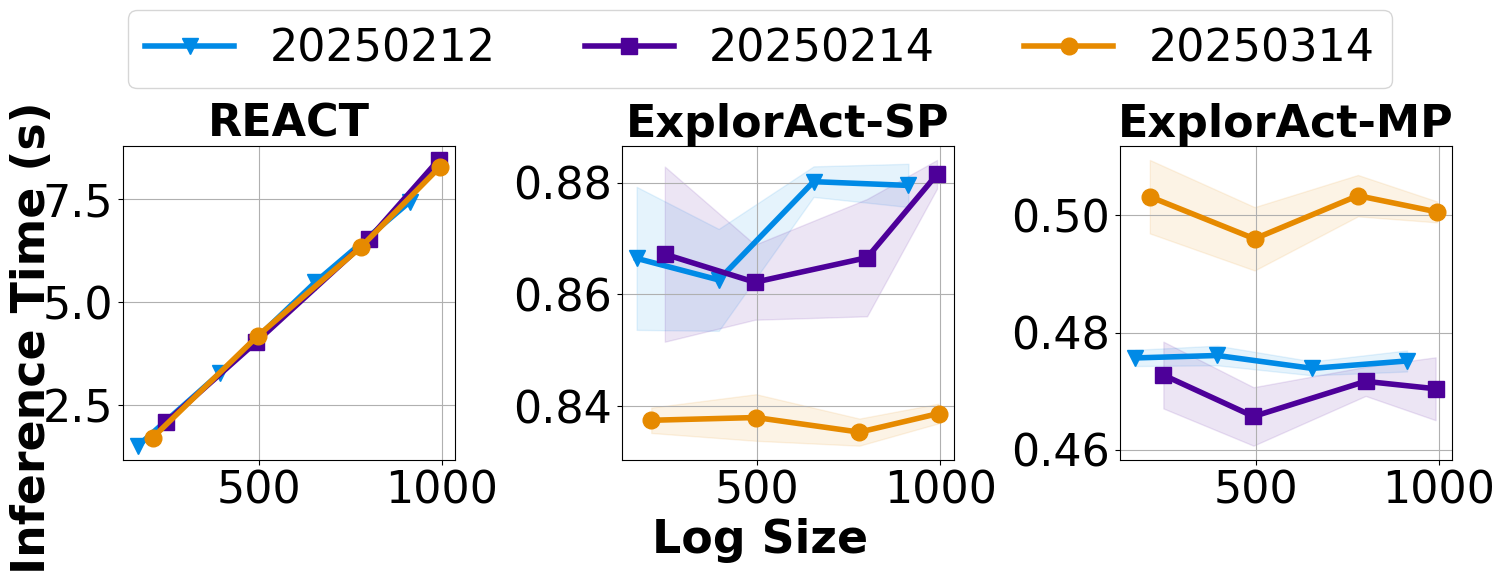

In [31]:
plt.close('all')

fontsize = 32
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

figure, axis = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(15, 5))

colors = ['#008ae6', '#4d0099', '#e68a00']
markers = ['v', 's', 'o']
msize=12

tau = u"\u03C4"
labels = [f"{tau}-rec", 'a-rec', f"({tau},a)-rec"]

titles = ['REACT', 'ExplorAct-SP', 'ExplorAct-MP']

for i in range(3):
    for j, seed in enumerate([20250212, 20250214, 20250314]):
        if i == 0:
            res = pickle.load(open(f'{data_path}/network_data/chunk_ted_results/{seed}_{3}_time.pickle', 'rb'))
            # print(res)
            x = res['log_sizes']
            times = np.array(res['time']) / 1e9
            axis[i].plot(x, times, marker=markers[j], markersize=msize, linestyle='-', linewidth=4, color=colors[j], label=f"{seed}")
        elif i == 1:
            res = pickle.load(open(f'{data_path}/network_data/model_stats/{seed}_{3}_gine_seq_logtime.pickle', 'rb'))
            x = res['log_sizes']
            avgs = np.array(res['avgs']) / 1e9
            stdevs = np.array(res['stdevs']) / 1e9
            axis[i].plot(x, avgs, marker=markers[j], markersize=msize, linestyle='-', linewidth=4, color=colors[j], label=f"{seed}")
            axis[i].fill_between(x, avgs - stdevs, avgs + stdevs, color=colors[j], alpha=0.1)
        elif i == 2:
            res = pickle.load(open(f'{data_path}/network_data/model_stats/{seed}_{3}_gine_own_logtime.pickle', 'rb'))
            x = res['log_sizes']
            avgs = np.array(res['avgs']) / 1e9
            stdevs = np.array(res['stdevs']) / 1e9
            axis[i].plot(x, avgs, marker=markers[j], markersize=msize, linestyle='-', linewidth=4, color=colors[j], label=f"{seed}")
            axis[i].fill_between(x, avgs - stdevs, avgs + stdevs, color=colors[j], alpha=0.1)

        axis[i].grid(True)
        axis[i].set_title(f'{titles[i]}', fontsize=fontsize, fontweight='bold')

handles, labels = axis[0].get_legend_handles_labels()
lgd = figure.legend(handles, labels, loc='upper center', ncols=4, fontsize=fontsize, bbox_to_anchor=(0.5, 1.2))
lblx = figure.supxlabel('Log Size', fontsize=fontsize+1, fontweight='bold', y=0.05)
lbly = figure.supylabel('Inference Time (s)', fontsize=fontsize+1, fontweight='bold', x=0.0000)
plt.tight_layout()
plt.savefig(f'{data_path}/network_data/time_plots/react_log_plot.pdf', format='pdf', bbox_extra_artists=(lgd, lblx, lbly), bbox_inches='tight')
plt.show()